# Training a self-driving car agent
## Reinforcement Learning Project
This documentation outlines the thought process behind training a smartcab to navigate on its own. We're applying reinforcement learning techniques for a self-driving agent in a simplified world to aid it in effectively reaching its destinations in the allotted time. 

First we'll investigate the given environment in which the agent operates in and instruct it, to execute very basic driving commands. Afterwards we'll exhibit the different states a smartcab can be in, analyzing its limited world and derive a Q-Learning algorithm, that will guide the agent towards its destination. At last we'll be going through several iterations in order to find the best configuration for our algorithm and the environment its operating in, to improve the results.

## Description
In the not-so-distant future, taxicab companies across the United States no longer employ human drivers to operate their fleet of vehicles. Instead, the taxicabs are operated by self-driving agents — known as smartcabs — to transport people from one location to another within the cities those companies operate. In major metropolitan areas, such as Chicago, New York City, and San Francisco, an increasing number of people have come to rely on smartcabs to get to where they need to go as safely and efficiently as possible. Although smartcabs have become the transport of choice, concerns have arose that a self-driving agent might not be as safe or efficient as human drivers, particularly when considering city traffic lights and other vehicles. To alleviate these concerns, your task as an employee for a national taxicab company is to use reinforcement learning techniques to construct a demonstration of a smartcab operating in real-time to prove that both safety and efficiency can be achieved.

## Software Requirements
This project uses the following software and Python libraries:

* [Python 2.7](https://www.python.org/download/releases/2.7/)
* [NumPy](http://www.numpy.org/)
* [PyGame](http://pygame.org/)
    * **Helpful links for installing PyGame:**
    * [Getting Started](https://www.pygame.org/wiki/GettingStarted)
    * [PyGame Information](http://www.pygame.org/wiki/info)
    * [Google Group](https://groups.google.com/forum/#!forum/pygame-mirror-on-google-groups)
    * [PyGame subreddit](https://www.reddit.com/r/pygame/)
    
## Definitions

### Environment
The smartcab operates in an ideal, simplified, grid-like city (see image below). Roads are established on two major axis (North-South & East-West). There are other vehicles on the road but the city is abstracted to a point where there are no other obstacles such as traffic jams, construction sights or other heterogenous agents such as pedestrians. However there are certain rules the city runs on, which are alike to our street system. At each intersection there is a traffic light that either allows traffic in the North-South direction or the East-West direction.

![Smart Cab Environment](smartcab_screenshot.png)

**Following rules guide the traffic:**
* On a green light, a left turn is permitted if there is no oncoming traffic making a right turn or coming straight through the intersection.
* On a red light, a right turn is permitted if no oncoming traffic is approaching from your left through the intersection.

### Inputs and Outputs
Very much alike to modern hail-a-cab applications the smartcab will have a route assigned based on t he passengers' starting location and the destination. The route is split at each intersection into waypoints, and for simplicity purposes the the smartcab is at some intersection at any instant in the world. 

Therefore, the next waypoint to the destination, assuming the destination has not already been reached, is one intersection away in one direction (North, South, East, or West). 

### States
The smartcab has only an egocentric view of the intersection it is at and can therefore use following information: 

* The state of the traffic light for its direction of movement: `['green', 'red']`
* Whether there is a vehicle at the intersection for each of the oncoming directions: `['left', 'right', 'oncoming']`

### Actions
For each action, the smartcab has one of the following options:

* Idle at the intersection
* Drive to the next intersection to either of the directions, which offers a set of following actions: `[None, 'left', 'right', 'forward']`

### Deadline
The smartcab has to get to its final destination in a given time. With each action taken, this time decreases. If the allotted time becomes zero before reaching the destination, the trip has failed.

### Rewards, Penalties and Goal
Smartcabs receive rewards for each successfully completed trip and smaller rewards for each action they execute successfully that obeys traffic rules. For any incorrect action a small penalty will be given and violating traffic rules or causing traffic accidents result in a high penalty. Based on the rewards and penalties the smartcab receives, the self-driving agent implementation will learn an optimal policy for driving on the city roads while obeying traffic rules, avoiding accidents, and reaching passengers' destinations in the allotted time.

## Implementing a Basic Driving Agent
In order to get going, we'll implement a basic driving agent that chooses from all possible actions one at random and drives through the city streets. 
In order to do so, we set `enforce_deadline` to `False` on line `47` and implement the following code in `agent.py` on line `30`:

In [2]:
# Pick a random action from set of possible actions. 
import random
action = random.choice([None, 'forward', 'left', 'right'])

In [3]:
# Quick code to demonstrate effect of actions allocation. 
n = 5
action_dict = []
for _ in range(n):
    action_dict.append(random.choice([None, 'forward', 'left', 'right']))
print "Smartcab performs following", n, "actions:", action_dict

Smartcab performs following 5 actions: ['left', None, None, 'right', None]


In order to make the observations countable we're implementing a code that counts each state where `deadline == 0` and `reward < 8` as not successful and states in which `reward >= 8` as successful attempts. We're choosing `8` as a reward boundary in order to account for possible negative rewards that are possible on the last attempt to get to the goal. For example if the car gets into an accident while going on the last field. Following code simulates this process:

In [4]:
import pandas as pd

# Create dict for trial summary
trial_summary = {}
# Initiate two states (0 = not successful, 1 = successful)
for i in range(2):
    trial_summary[i] = 0

for i in range(100):
    # Initiate dummy variables
    deadline = 0
    reward = 0
    
    # Simulates 10% of attempts being successful
    if (i % 10 == 0):
        deadline = 1
        reward = 8
    if (deadline == 0) & (reward < 8):
        trial_summary[0] += 1
    elif (reward >= 8):
        trial_summary[1] += 1

success_summary = pd.DataFrame.from_dict(trial_summary, orient='index')
success_summary.columns = ['trial_count']
success_summary.index = ['no_success', 'success']
success_summary

,trial_count
no_success,90
success,10


As mentioned we'll implement a loop that executes the trials n-times, store the results in a table and takes the average over all n attempts for better comparision.

`basic_agent.py` looks like follows:

```python
import pandas as pd
import random
from collections import Counter
from environment import Agent, Environment
from planner import RoutePlanner
from simulator import Simulator

class LearningAgent(Agent):
    """An agent that learns to drive in the smartcab world."""

    def __init__(self, env):
        super(LearningAgent, self).__init__(env)  # sets self.env = env, state = None, next_waypoint = None, and a default color
        self.color = 'taxi'  # override color
        self.planner = RoutePlanner(self.env, self)  # simple route planner to get next_waypoint
        # TODO: Initialize any additional variables here
        self.trial_count = 0
        self.trial_summary = {}
        for i in range(2):
            self.trial_summary[i] = 0

    def reset(self, destination=None):
        self.planner.route_to(destination)
        # TODO: Prepare for a new trip; reset any variables here, if required
        self.trial_count = 0
        #self.trial_summary[0] = 0
        #self.trial_summary[1] = 0

    def update(self, t):
        # Gather inputs
        self.next_waypoint = self.planner.next_waypoint()  # from route planner, also displayed by simulator
        inputs = self.env.sense(self)
        deadline = self.env.get_deadline(self)

        # TODO: Update state
        
        # TODO: Select action according to your policy
        action = random.choice([None, 'forward', 'left', 'right'])

        # Execute action and get reward
        reward = self.env.act(self, action)

        # TODO: Learn policy based on state, action, reward

        print "LearningAgent.update(): deadline = {}, inputs = {}, action = {}, reward = {}".format(
            deadline, inputs, action, reward)  # [debug]

        if (deadline == 0) & (reward < 8):
            self.trial_summary[0] += 1
            print "#" * 20
            print "Trial was unsuccessful."
            print "#" * 20
        else:
            if (reward >= 8):
                self.trial_summary[1] += 1
                print "#" * 20
                print "Trial was successful."
                print "#" * 20

def run():
    """Run the agent for a finite number of trials."""

    # Set up environment and agent
    e = Environment()  # create environment (also adds some dummy traffic)
    a = e.create_agent(LearningAgent)  # create agent
    e.set_primary_agent(a, enforce_deadline=False)  # specify agent to track
    # NOTE: You can set enforce_deadline=False while debugging to allow longer trials

    # Now simulate it
    # create simulator (uses pygame when display=True, if available)
    sim = Simulator(e, update_delay=0, display=False)  
    # NOTE: To speed up simulation, reduce update_delay and/or set display=False

    success_summary = pd.DataFrame(index = ['no_success', 'success'])
    validation_no = 10

    for i in range(validation_no):
        sim.run(n_trials=100)  # run for a specified number of trials
        # NOTE: To quit midway, press Esc or close pygame window, or hit Ctrl+C on the command-line
        print "Trial Count: ", a.trial_count
        success_temp = pd.DataFrame.from_dict(a.trial_summary, orient='index')
        success_temp.index = ['no_success', 'success']
        temp_column_name = 'trial_count_' + str(i+1)
        #success_temp.columns = [temp_column_name]
        success_summary[temp_column_name] = success_temp
        a.trial_summary[0] = 0
        a.trial_summary[1] = 0
    #print "Arrived", Counter(a.trial_summary.values()).most_common()[1][1], "times."
    print success_summary
    success_average = success_summary.mean(axis=1)
    print "Average: "
    print success_average
    print "Percentage: ", success_average[0:][1] / success_average[0:][0] 

if __name__ == '__main__':
    run()
```

### Observations
> There are a couple interesting observations when you run the smartcab with nothing but random actions:

> * When crashing, cars will restart at a different location and start to perform actions again.
> * There are 3 other agents or cars in play.
> * With n $\rightarrow \infty$ (through `enforce_deadline = False`) the agent reaches the goal eventually if it doesn't crash into another vehicle.
> * There is a reward system in place that shows the immediate gratification of an action.

> When we set `enforce_deadline` to `False` and let it run 10 times with `n_trials = 100` we get following averaging stats:

> |               | trial_count   |
> | ------------- | ------------- |
> | no_success    | 79.5          |
> | success       | 20.5          |

> Which indicates that only 25.78 % of all agents reach their destination in the given time. Not very convenient for our passengers. This is the measure we would like to improve significantly down the road. 
The data corresponding to this claim can be found here: `smartcab/data/basic_agent_trials.csv`

In [12]:
basic_agent_trials = pd.read_csv('smartcab/data/basic_agent_trials.csv', index_col=0)
basic_agent_trials

,trial_count_1,trial_count_2,trial_count_3,trial_count_4,trial_count_5,trial_count_6,trial_count_7,trial_count_8,trial_count_9,trial_count_10
no_success,73,79,76,78,80,87,77,82,77,86
success,27,21,24,22,20,13,23,18,23,14


In [14]:
basic_agent_trials.mean(axis=1)

no_success    79.5
success       20.5
dtype: float64

### Inform the Driving Agent
Now that the driving agent is capable of moving around in the environment, the next task is to identify a set of states that are appropriate for modeling the smartcab and environment. 

The main source of state variables are the current inputs at the intersection, but given our set of rules not all may require representation. The goal is, to process the inputs and update the agent's current state at each waypoint using the `self.state` variable. In order to check our performance we'll continue with the simulation deadline enforcement `enforce_deadline` being set to `False`.

#### All information available
Let's take a look at all information we've got available in our environment and talk through the possibilities that come with each of these inputs.

##### Traffic Lights
As mentioned above, we have an indicator that shows what color the traffic light at any given position of the agent has. This can take the values `green` and `red`. We find this information in the inputs dictionary and can call it with `inputs['light']`. Given our set of rules, this is a highly useful indicator for our smartcab to decide whether it should perform a certain action or not. This information will be included in our set of state variables.

```python
* `inputs['light'] = ['red', 'green']`
```

##### Traffic
Our agent can detect, whether there is a vehicle at the intersection for each of the oncoming directions and what action this other agent is performing. Given the set of rules that apply on US streets we have following information that we need to especially emphasize:

* If the traffic light is green:
    * Is there oncoming traffic going in my direction? ($\rightarrow$ can't perform a left turn)
* If the traffic light is red:
    * Is there traffic coming from the left side? ($\rightarrow$ can't make a right turn)

However since we want to let our agent learn these rules through reinforcement and gratification we are going to add all the information about traffic in our set of states. This adds following set to the list: 

```python
* `inputs['oncoming'] = [None, 'left', 'right', 'forward']`
* `inputs['left'] = [None, 'left', 'right', 'forward']`
* `inputs['right'] = [None, 'left', 'right', 'forward']`
```

##### Waypoints
The decision, which step to perform next is essential to learning if some action is good or bad, given the state. Especially in reinforcement learning. If you compare it to a simple but hurtful early life analogy, this is where our agent will understand if the cooktop is hot or not.

```python
* `self.next_waypoint = ['forward', 'left', 'right']`
```

##### Deadline
One could argue that the time that is available for the smartcab to perform its delivery describes the state its in. We can think about classic situations where cab drivers are pushed to their limits and into breaking the law in order to get a passenger faster to the destination. Since we're building this system though, to perform optimal results without breaking the law we should discard this input though. 
Another valid concern is the number of possible combinations. Given that the deadline reduces by `1` on each action we perform an average of 40 to 50 actions each run, this would add a multiplier of `len(deadline)` to the state combinations that we already have. With only 100 training runs including around 40 to 50 actions in each run this might be a state input that rather distracts the learner from learning what's essential for the task.

##### The final states for our Q-Learner
>To summarize, we're planning on including following inputs to the list of possible state combinations:

> ```python
* `inputs['light'] = ['red', 'green']` -> 2
* `inputs['oncoming'] = [None, 'left', 'right', 'forward']` -> 4
* `inputs['left'] = [None, 'left', 'right', 'forward']` -> 4
* `inputs['right'] = [None, 'left', 'right', 'forward']` -> 4
* `self.next_waypoint = ['forward', 'left', 'right']` -> 3
```

The total number of states therefore is the combination of all states:
$$ 2 * 4 * 4 * 3 = 384 $$

**Does this number seem reasonable given that the goal of Q-Learning is to learn and make informed decisions about each state?**

>Given that we are dealing with around `5000` waypoints in our training runs (`100` runs * `~50` actions), the amount of `384` states seems to be a bit high. We could consider dropping `inputs['right']`, since given our rules if the traffic light is red and we want to make a right turn (which is allowed by US rules) this would be a correct action that wouldn't end up in an accident but all other actions would be incorrect and therefore should be learned as being incorrect. This would bring down the number of states to `96` but we would lose some flexibility, if we for example would change the rules slightly and appply it to a European traffic setting our Reinforcement Learner would learn incorrect rules. Since we'll be adding each state as a combination when it occures to a dictionary and calculate its given value we might not even end up evaluating and adding all `384` states. Therefore it should be alright to add all appearances out of `384` possible combinations.



## Implement a Q-Learning Driving Agent
With the driving agent being capable of interpreting inputs and having a mapping of environmental states, we now want to make her understand how to best choose actions given this information. In order to do so, we are implementing an algorithm called Q-Learning. 
Q-Learning will essentially compute the best action based on rewards given by states that the agent goes through. The Q-Learning driving agent will need to consider these rewards when updating its Q-values.

Specialty: Stochastic vs. Deterministic

The algorithm can be described as follows:

1. Initialize $Q(s, a)$ arbitrarily
2. For life or until learning is stopped...
    3. Initialize $s$
    4. Repeat (for each step of episode):
        5. Choose $a$ from $s$ using policy derived from $Q$ (using i.e. ε greedy)
        6. Take action $a$, observe reward $r$ at state $s'$
        7. Update: $Q(s,a) \leftarrow Q(s,a) + \alpha * [r + \gamma * (max_{\alpha}Q(s',a') − Q(s,a))]$
        8. $s \leftarrow s'$;
    9. Until $s$ is terminal


* Where $\alpha$ is the learning rate set between `[0, 1]`.
* $\gamma$ is the discount factor which models the fact that future rewards are worth less than immediate rewards.

[Input from Faculty of Engineering UNSW](http://www.cse.unsw.edu.au/~cs9417ml/RL1/algorithms.html)

**ε greedy strategy**

The ε-greedy strategy is to select the greedy action (one that maximizes Q[s,a]) all but ε of the time and to select a random action ε of the time, where 0 ≤ ε ≤ 1. It is possible to change ε through time. Intuitively, early in the life of the agent it should select a more random strategy to encourage initial exploration and, as time progresses, it should act more greedily.

One problem with an ε-greedy strategy is that it treats all of the actions, apart from the best action, equivalently. If there are two seemingly good actions and more actions that look less promising, it may be more sensible to select among the good actions: putting more effort toward determining which of these promising actions is best, rather than putting in effort to explore the actions that look bad. One way to do that is to select action a with a probability depending on the value of Q[s,a]. This is known as a soft-max action selection.
[AI - Foundations of Computational Agents](http://artint.info/html/ArtInt_266.html)

**What changes do you notice in the agent's behavior when compared to the basic driving agent when random actions were always taken?** 
> Below are observations of the biggest changes noticable compared to the basic driving agent:
> * The biggest change that can be noticed is, the agent starts heading towards the destination even early in the process when almost no rules have been learned yet.
> * There are no crashes that happen any more.
> * The agent stops at certain points, when needed but doesn't halt at a stop when the light is green and there is no interfering traffic.
> * The agent also learns that running over a red light is a bad choice and learns to either wait or pick a different route.


**Why is this behavior occurring?**
> * It becomes obvious that the agent tries to maximize the actions that are producing the highest reward.
> * By adding a certain randomness to the algorithm (through a $\epsilon$ greedy implementation) we're taking into account to make mistakes but avoid learning a semi-optimal policy.

In [38]:
# Different algorithm where epsilon doesn't really play a role
feature_comp_all = pd.read_csv('smartcab/data/feature_comparison_all.csv', sep = ';')
feature_comp_all.sort_values(['success', 'steps'], ascending=[False, True]).head()

,alpha,gamma,epsilon,no_success,success,steps
79,0.90,0.05,1.0,0.2,99.8,10.8
29,0.30,0.05,1.0,0.4,99.6,11.2
14,0.05,0.60,1.0,0.4,99.6,14.4
59,0.60,0.30,1.0,0.4,99.6,15.2
19,0.05,0.90,1.0,0.4,99.6,18.6


In [39]:
# Implementing e_greedy algorithm where epsilon stands for a percentage 
# of how often the right action is being chosen.
feature_comp_e_greedy = pd.read_csv('smartcab/data/feature_comparison_e_greedy.csv', sep = ';')
feature_comp_e_greedy.sort_values(['success', 'steps'], ascending=[False, True]).head()

,alpha,gamma,epsilon,no_success,success,steps
54,0.60,0.05,1.0,0.2,99.8,10.2
4,0.05,0.05,1.0,0.2,99.8,14.0
9,0.05,0.30,1.0,0.2,99.8,17.2
104,1.00,0.05,1.0,0.4,99.6,11.4
119,1.00,0.90,1.0,0.4,99.6,13.2


$$ ε_{t} = \frac{1}{1 + e^{-t}} $$

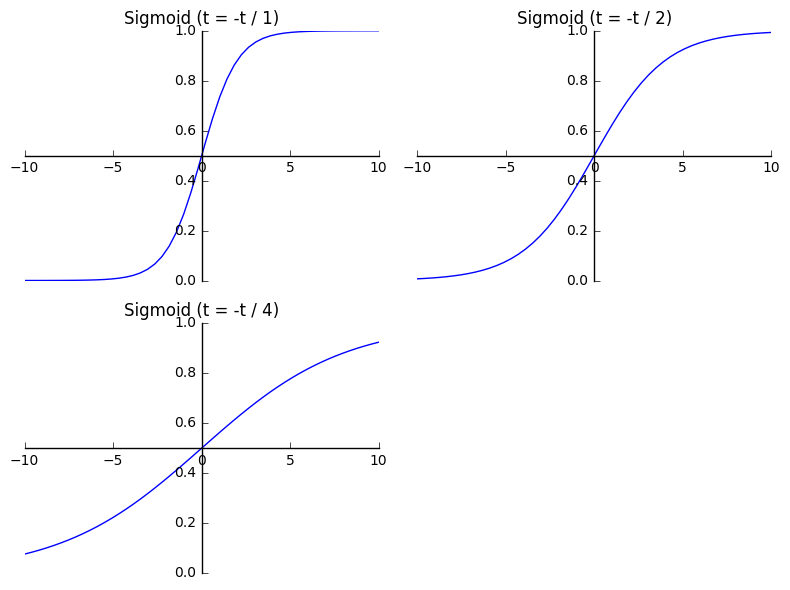

In [110]:
# Sigmoid curve
import numpy as np
import pylab
from scipy.optimize import curve_fit


xdata = np.array(range(-10,11,1))
ydata = np.array([0.01, 0.02, 0.04, 0.11, 0.43,  0.7, 0.89, 0.95, 0.99])
x = np.linspace(-10, 10, 50)

pylab.figure(1, figsize=(8,6))

plotno = 221
for nom in [1, 2, 4]:
    def sigmoid(k):
        return 1 / (1 + np.exp(-k/nom))
    
    y = sigmoid(x)
    ax = pylab.subplot(plotno)
    
    # Move left y-axis and bottim x-axis to centre, passing through (0,0)
    ax.spines['left'].set_position('center')
    ax.spines['bottom'].set_position('center')

    # Eliminate upper and right axes
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

    # Show ticks in the left and lower axes only
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.title.set_text('Sigmoid (t = -t / ' + str(nom) + ')')
    
    pylab.plot(x,y)
    
    plotno += 1

pylab.tight_layout()

pylab.show()

In [42]:
# Implementation of e_greedy algorithm where epsilon increases over time 
# -> The more steps I take the better my actions get
feature_comp_sig_e = pd.read_csv('smartcab/data/feature_comparison_e_greedy_sig_e.csv', sep = ';')
feature_comp_sig_e.sort_values(['success', 'steps'], ascending=[False, True]).head()

,alpha,gamma,epsilon,no_success,success,steps
0,0.05,0.05,1,0.2,99.8,18.0
4,0.05,1.00,1,0.4,99.6,13.8
6,0.30,0.30,1,0.4,99.6,18.6
10,0.60,0.05,1,0.6,99.4,16.2
15,0.90,0.05,1,1.0,99.0,12.8


$$ α_{t} = \frac{1}{1 + e^{t}} $$

In [45]:
# Decreasing alpha and increasing epsilon
feature_comp_a_and_e = pd.read_csv('smartcab/data/feature_comparison_ae_sig.csv', sep = ';')
feature_comp_a_and_e.sort_values(['success', 'steps'], ascending=[False, True])

,alpha,gamma,epsilon,no_success,success,steps
0,1,0.05,1,0.8,99.2,13.4
4,1,1.00,1,1.0,99.0,12.0
1,1,0.30,1,2.6,97.4,11.4
2,1,0.60,1,4.8,95.2,13.0
3,1,0.90,1,7.6,92.4,12.2


$$ ε_{t} = \frac{1}{1 + e^{\frac{-t}{2}}} $$
$$ α_{t} = \frac{1}{1 + e^{\frac{t}{2}}} $$

In [46]:
# Possible Problem: Sigmoid moves to fast. Divide time it takes by 2
feature_comp_slow_sig = pd.read_csv('smartcab/data/feature_comparison_ae_slow_sig.csv', sep = ';')
feature_comp_slow_sig.sort_values(['success', 'steps'], ascending=[False, True])

,alpha,gamma,epsilon,no_success,success,steps
0,1,0.05,1,1.2,98.8,12.2
1,1,0.30,1,1.2,98.8,12.6
2,1,0.60,1,4.8,95.2,15.6
3,1,0.90,1,15.4,84.6,11.8
4,1,1.00,1,35.2,64.8,23.6


Reasoning for Gamma
Gamma is the value of future reward. It can affect learning quite a bit, and can be a dynamic or static value. If it is equal to one, the agent values future reward JUST AS MUCH as current reward. This means, in ten actions, if an agent does something good this is JUST AS VALUABLE as doing this action directly. So learning doesn't work at that well at high gamma values.

Conversely, a gamma of zero will cause the agent to only value immediate rewards, which only works with very detailed reward functions.

Reasoning for Alpha
Alpha is the learning rate. If the reward or transition function is stochastic (random), then alpha should change over time, approaching zero at infinity. This has to do with approximating the expected outcome of a inner product (T(transition)*R(reward)), when one of the two, or both, have random behavior.

let's adjust gamma and let it rise very slowly

$$ γ_{t} = \frac{1}{1 + e^{\frac{t}{4}-3}} $$
$$ γ_{t} = \frac{1}{1 + e^{\frac{t}{4}}} $$
$$ γ_{t} = \frac{1}{1 + e^{\frac{t}{2}}} $$
$$ γ_{t} = \frac{1}{1 + e^{\frac{-t}{4}+3}} $$
$$ γ_{t} = \frac{1}{1 + e^{\frac{-t}{4}}} $$
$$ γ_{t} = \frac{1}{1 + e^{\frac{-t}{2}}} $$

In [56]:
feature_comp_aeg_slow_sig = pd.read_csv('smartcab/data/feature_comparison_aeg_slow_sig.csv', sep = ';')
feature_comp_aeg_slow_sig.drop([1, 3, 5, 7, 9], inplace=True)
feature_comp_aeg_slow_sig.index = ['(t/4) -3', '(t/4)', '(-t/4)+3', '(-t/4)', '(-t/2)', '(t/2)']
feature_comp_aeg_slow_sig.sort_values(['success', 'steps'], ascending=[False, True])

,alpha,gamma,epsilon,no_success,success,steps
(t/2),1,1,1,1.2,98.8,14.8
(-t/4)+3,1,1,1,2.2,97.8,18.2
(t/4),1,1,1,2.8,97.2,15.6
(-t/4),1,1,1,8.6,91.4,13.4
(-t/2),1,1,1,9.6,90.4,17.6
(t/4) -3,1,1,1,16.0,84.0,23.6


Improve the Q-Learning Driving Agent
Your final task for this project is to enhance your driving agent so that, after sufficient training, the smartcab is able to reach the destination within the allotted time safely and efficiently. Parameters in the Q-Learning algorithm, such as the learning rate (alpha), the discount factor (gamma) and the exploration rate (epsilon) all contribute to the driving agent’s ability to learn the best action for each state. To improve on the success of your smartcab:

Set the number of trials, n_trials, in the simulation to 100.
Run the simulation with the deadline enforcement enforce_deadline set to True (you will need to reduce the update delay update_delay and set the display to False).
Observe the driving agent’s learning and smartcab’s success rate, particularly during the later trials.
Adjust one or several of the above parameters and iterate this process.
This task is complete once you have arrived at what you determine is the best combination of parameters required for your driving agent to learn successfully.

QUESTION: Report the different values for the parameters tuned in your basic implementation of Q-Learning. For which set of parameters does the agent perform best? How well does the final driving agent perform?

QUESTION: Does your agent get close to finding an optimal policy, i.e. reach the destination in the minimum possible time, and not incur any penalties? How would you describe an optimal policy for this problem?